<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;"> 
              <h1>
               <left>Basic Image Segmentation in Python</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: BIOM 480A5, Spring 2025
Instructor: Brian Munsky
Authors: Dr. Zach Fox, Dr. Luis Aguilera, Brian Munsky
Contact Info: munsky@colostate.edu
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2024 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



# Abstract

In this notebook, we will talk about single-cell segmentation and spot detection using Python. By now, we have covered basic image manipulation (see Module 4A and 4B). Here, our goal is introduce the basics of single-cell segmentation and particle detection.

## Learning Objectives
After completing this notebook, you should be able to:

1. Explain the more common methods used to segment cells from microscope images.
2. Explain what a ***segmentation mask is***.
3. Explain and be able to execute basic segmentation methods based on **threshold selection**.
4. Perform single-cell segmentation using modern **machine learning** based methods using CellPose
5. Understand the basics of **particle detection**.

# 1. Introduction to segmentation

![alt text](FigsA/Module_1_3/Slide2.png)

Main steps of (cell) segmenation and spot detection:

1.   Thresholding
2.   Binarization
3.   Labeling

![alt text](FigsA/Module_1_2/Slide2.png)

<img src= https://github.com/MunskyGroup/uqbio2022/raw/master/files/files_image_processing/module_1_2/images/Slide3.png alt="drawing" width="1200"/>

![alt text](FigsA/Module_1_2/Slide4.png)

## Manual segmentation software
Using software such as [ImageJ/FIJI](https://imagej.nih.gov/ij/), [Napari](https://napari.org) or even something like Microsoft Paint, one can manually outline cells. 

This can be cumbersome and impractical for processing thousands of cells over time.

![alt text](FigsA/Module_1_2/Slide5.png)

Check out this tool ([makesense](https://www.makesense.ai)) to create your own masks.

You can find some images in the following [link](https://www.dropbox.com/s/d9my4cp2j3ven04/test_data_uqbio2022.zip?dl=0)

# 2. Segmentation using Thresholding approaches

## 2.A. Watershed Methods
The scikit-image library has an excellent tutorial on [watershed methods](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html). Popular tools that apply such methods to single cells are:
* [CellStar](http://cellstar-algorithm.org) (Matlab, Python, CellProfiler PlugIn)
* [FogBank](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-014-0431-x#additional-information) (Matlab)

![alt text](FigsA/Module_1_2/Slide6.png)

In [1]:
# !pip install --upgrade  cellpose
# os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

from cellpose import plot, models
# Note -- your kernel may crash when running this cell. 
# If it does, just restart the kernel and run this cell again.

In [2]:
# Loading libraries
import random                        # Library to generate random numbers
import skimage                       # Library for image manipulation
import numpy as np                   # Library for array manipulation
import urllib.request                # Library to download data
import matplotlib.pyplot as plt      # Library used for plotting
from skimage import io, measure      # Module from skimage
from skimage.io import imread        # Module from skimage to read images as numpy arrays
from skimage.filters import gaussian # Module working with a gaussian filter
import pathlib                              # Library to work with file paths
import os
%matplotlib inline

!pip install ipywidgets
from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets

from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
from skimage.draw import polygon
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import difference_of_gaussians

Let's get started by downloading a sample image of a cell and plotting it using `matplotlib`:


In [3]:
# Downloading a test image
urls = ['https://ndownloader.figshare.com/files/26751209']
print('Downloading file...')
figName = './image_cell.tif'
urllib.request.urlretrieve(urls[0], figName)
# Loading figure to the notebook
images = imread(figName)
print('File is downloaded and accessible in: ... ./image_cell.tif ')


File is downloaded and accessible in: ... ./image_cell.tif 


In [4]:
# How do we find the figure we just saved?  I.e., what is figName = './image_cell.tif'   
# What is our current working directory (cwd)?    #import os #os.getcwd()
print(f'Our cvw is : {os.getcwd()}')

# What is the absolute path to the file?  #import os #os.path.abspath(figName)
print(f'The absolute path to the file is : {os.path.abspath(figName)}')


Our cvw is : /Users/munsky/Dropbox/Teaching_Projects/Course Materials/BIOM 4XX - Computational Anaalyses for BIOM/Codes2025/480A5CourseMaterials/Module4-ImageProcessing
The absolute path to the file is : /Users/munsky/Dropbox/Teaching_Projects/Course Materials/BIOM 4XX - Computational Anaalyses for BIOM/Codes2025/480A5CourseMaterials/Module4-ImageProcessing/image_cell.tif


In [5]:
# Printing the shape of the image
print('Original image shape: ' , images.shape)  # [T,Y,X,C]

# Selecting a frame and a color channel
img = images[0,:,:,0]
print('Single image shape: ' , img.shape)  # [Y,X]

Original image shape:  (35, 512, 512, 3)
Single image shape:  (512, 512)


In [6]:
# What is the difference  between "images" and "img" after the above code?

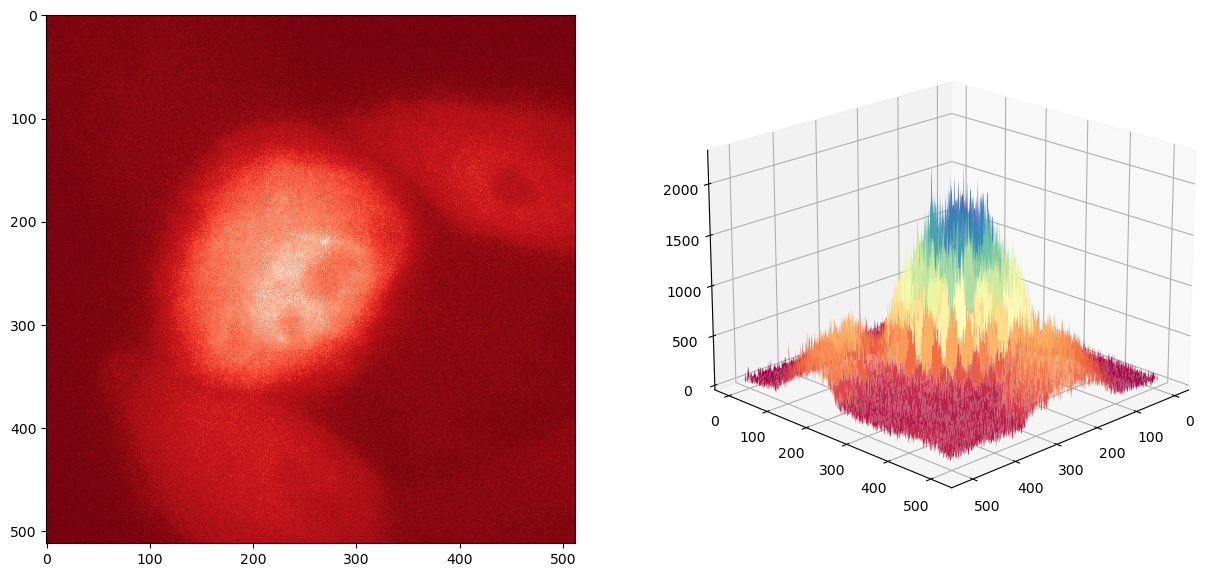

In [7]:
# Plotting the image as the 3d dimension figure.
space= np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(space,space)
fig = plt.figure(figsize=(15,7))

# Set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img,cmap='Reds_r') # Reds_r

# Set up the axes for the second plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(xx, yy , img,  rstride=20, cstride=20, shade=False, cmap='Spectral')
ax2.view_init(20, 45)
plt.show()

Recall when we plotted the histogram of the intensity pixels to get a sense of the distribution of pixel intensities throughout the image. Let's do that again here.

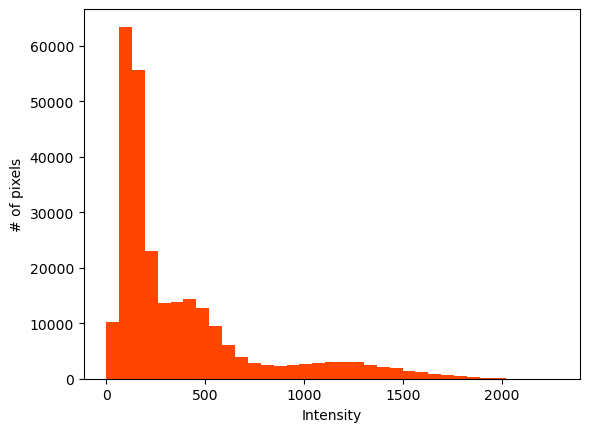

In [8]:
# Plotting the intensity distribution
f, ax = plt.subplots()
ax.hist(img.flatten(),color='orangered',bins=35)  # .ravel()
ax.set_xlabel('Intensity')
ax.set_ylabel('# of pixels')
plt.show()

In [9]:
# There are three peaks in the histogram. What do you think they represent?


## 2.B. Segmentaton based on threshold selection

Based on this image, we can guess a threshold of pixel intensities that are "cells" vs "not cells". What do you think would make a good threshold?

In [10]:
# Thresholding the image
def viewer(threshold=50):
    mask_image = np.zeros(img.shape)
    mask_image[img>threshold] = 255
    f,ax = plt.subplots()
    ax.imshow(mask_image, cmap='Greys')
    plt.show()

interactive_plot = interactive(viewer,threshold = widgets.IntSlider(min=0,max=2000,step=1,value=0,description='threshold'))       
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))    

This mask image is useful, especially considering we simply took all of the pixels with a value bigger than `threshold`.

However, we know that the outside ought to be more smooth. Let's try applying a Gaussian filter to smooth out the mask image:


In [11]:
# Thresholding the image
def viewer(threshold=50, sigma=5):
    mask_image = np.zeros(img.shape)
    mask_image[img>threshold] = 255
    new_mask = gaussian(mask_image, sigma=sigma)
    f,ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(mask_image, cmap='Spectral')
    ax[1].imshow(new_mask, cmap='Spectral')
    plt.show()
    return new_mask

interactive_plot = interactive(viewer, \
            threshold = widgets.IntSlider(min=0,max=2000,step=1,value=0,description='threshold'),\
            sigma = widgets.IntSlider(min=0,max=10,step=1,value=0,description='sigma'))       

controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))    

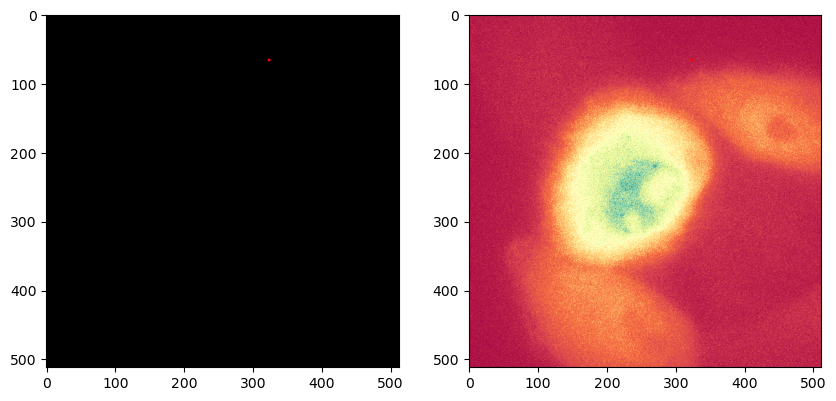

In [12]:
# Plotting all contours detected in the filtered image
new_mask = interactive_plot.result

f,ax = plt.subplots(1,2, figsize=(10,5))
contours = measure.find_contours(new_mask, level=125 ) # level is half of 255 (ish). What happens if we change it?
contours_connected = np.vstack((contours))
ax[0].imshow(new_mask, cmap='Greys')
ax[1].imshow(images[0,:,:,0], cmap='Spectral')
for contour in contours:
  ax[0].plot(contour[:,1],contour[:,0],color='r')  
  ax[1].plot(contour[:,1],contour[:,0],color='r')

plt.show()

In [13]:
# How would I learn how the function find_contours works?  
help(measure.find_contours)

Help on function find_contours in module skimage.measure._find_contours:

find_contours(image, level=None, fully_connected='low', positive_orientation='low', *, mask=None)
    Find iso-valued contours in a 2D array for a given level value.
    
    Uses the "marching squares" method to compute the iso-valued contours of
    the input 2D array for a particular level value. Array values are linearly
    interpolated to provide better precision for the output contours.
    
    Parameters
    ----------
    image : (M, N) ndarray of double
        Input image in which to find contours.
    level : float, optional
        Value along which to find contours in the array. By default, the level
        is set to (max(image) + min(image)) / 2
    
        .. versionchanged:: 0.18
            This parameter is now optional.
    fully_connected : str, {'low', 'high'}
         Indicates whether array elements below the given level value are to be
         considered fully-connected (and hence ele

So far so good. By setting `threshold=700` we were able to find the "main" cell in the image. But what happens when we want to get all three? Try lowering the threshold to  300 and running the code.

_it looks like a crab_ !


In the cell below, we will try to take the connected image below and use a [watershed algorithm](https://en.wikipedia.org/wiki/Watershed_(image_processing) to break it into 3 distinct cells.

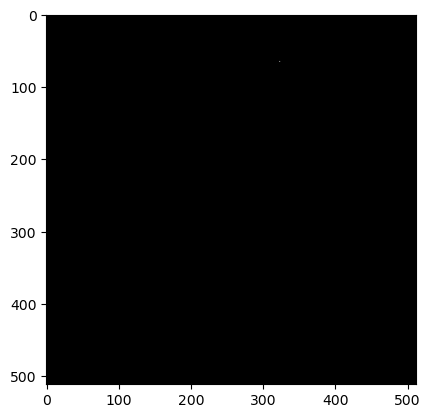

min value in mask:  0
max value in mask:  1


In [14]:
# make a new mask from the contours array
watershed_starting_mask = np.zeros(img.shape).astype(int)                    # Prealocating an array with zeros. Notice the datatype.
rr, cc = polygon(contours_connected[:,0], contours_connected[:,1])           # Returns the coordinates inside the contour
watershed_starting_mask[rr,cc] = 1                                           # Replacing all values inside the contour with ones.

# Plotting the mask
f,ax = plt.subplots()
ax.imshow(watershed_starting_mask, cmap='Greys_r')
plt.show()

# Printing the minimum and maximum values in the image
print('min value in mask: ', np.min(watershed_starting_mask) )
print('max value in mask: ', np.max(watershed_starting_mask) )

To find more information about the specific method use

```
help(watershed)
```



## 2.C. Distance transform



"The distance transform computes the distance between each pixel and the nearest zero/nonzero pixel." An example with code implementation is accessible in this [link](https://www.youtube.com/watch?v=oxWfLTQoC5A).

For more infromation about the distance transform check this [link](https://homepages.inf.ed.ac.uk/rbf/HIPR2/distance.htm)

<img src= https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/distance.gif alt="drawing" width="600"/>



By  using the distance transform we can find basins in the center of each cell.

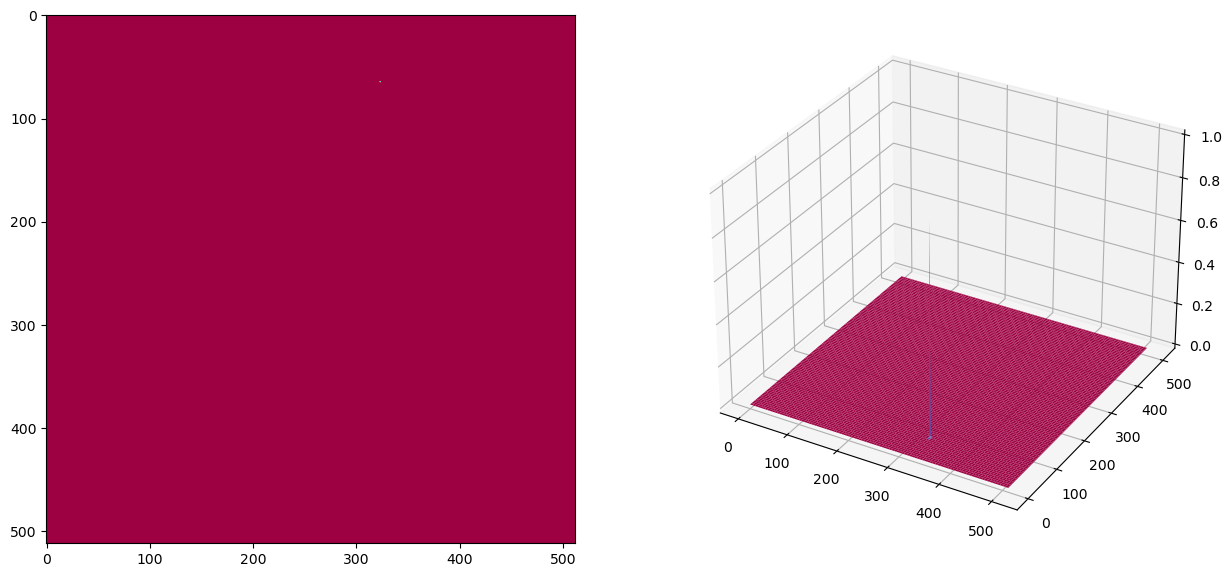

In [15]:
# Computes the Distance Transform distance in the image
distance = ndi.distance_transform_edt(watershed_starting_mask)

# Plotting the image as the 3d dimension figure.
space= np.arange(0, distance.shape[0], 1)
xx, yy = np.meshgrid(space,space)
fig = plt.figure(figsize=(15,7))
# Set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
ax.imshow(distance,cmap='Spectral') # Reds_r
# Set up the axes for the second plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(xx, yy , distance,  rstride=5, cstride=5, shade=False, cmap='Spectral')
#ax2.view_init(30, 45)
plt.show()

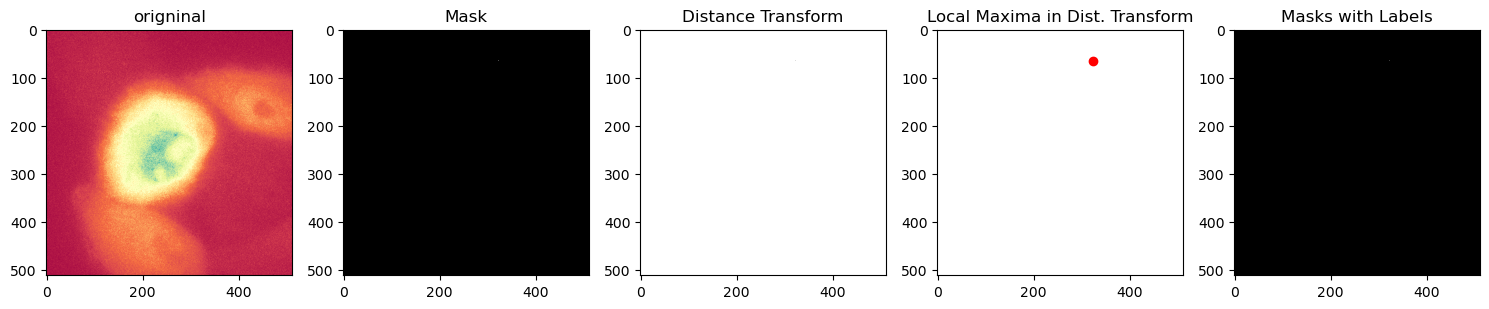

In [16]:
# Apply watershed
# Compute the Distance Transform distance in the image
distance = ndi.distance_transform_edt(watershed_starting_mask)                       # Computes the Distance Transform distance in the image

# Use the Distance transform image to find local maxima
coords = peak_local_max(distance, min_distance=50, labels=watershed_starting_mask)  

 # Selecting unique indexes
_,inds = np.unique(distance[coords[:,0],coords[:,1]],return_index=True)      # Make sure they are unique
coords = coords[inds,:]                                                     

# Create a mask associated with the local maxima
mask = np.zeros(distance.shape, dtype=bool)        # Prealocating an array with zeros
mask[tuple(coords.T)] = True                       # Make an image with 1's where local maxima are
markers, _ = ndi.label(mask)                       # Unique values used as the desired labels

# Using the watershed algorithm
labels = watershed(-distance, markers, mask=watershed_starting_mask, watershed_line=True)  
#Why do we need to use the negative of the distance matrix?

# Plot the results
f,ax = plt.subplots(1,5, figsize=(15,7))
ax[0].imshow(img, cmap='Spectral')
ax[0].set_title('origninal')
ax[1].imshow(watershed_starting_mask, cmap='Greys_r')
ax[1].set_title('Mask')
ax[2].imshow(ndi.distance_transform_edt(watershed_starting_mask), cmap='Greys')
ax[2].set_title('Distance Transform')
ax[3].imshow(ndi.distance_transform_edt(watershed_starting_mask), cmap='Greys')
ax[3].scatter(coords[:,1],coords[:,0],c='r')
ax[3].set_title('Local Maxima in Dist. Transform')
ax[4].imshow(labels, cmap='gray') #Spectral
ax[4].set_title('Masks with Labels')
f.tight_layout()

plt.show()

# 3. **Masks** and **Labels**

A **mask** is a binary image that indicates the presence and boundaries of a cell (or other object) in an image. 

A **label** is an integer value that indicates the identity of each such object in an image. 

By thinking in terms of masks and labels, we can easily focus on objects in the image one at a time and explore various propeties of the objects.

The shape of our image is (35, 512, 512, 3)
The shape of our labels is (512, 512)


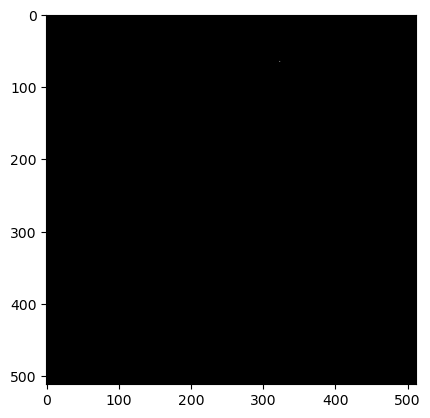

In [17]:
# How would I show an image of just the first cell?
# Remember,
print(f'The shape of our image is {images.shape}')
print(f'The shape of our labels is {labels.shape}')

# How should I change this?
plt.imshow((labels==3), cmap='gray')
plt.imshow(labels, cmap='gray')


# 4. Machine Learning Methods for Segmentation


In recent years, deep learning methods have rapidly improved the state of the art for cell segmentation methods. The main workhorse for modern image analysis is based heavilly on **Convolutional Neural Networks** (CNNs).

## 4.A. Introduction to Convolutional Neural Networks (CNNs) for Modern Image Analysis

**Convolutional Neural Networks (CNNs)** are a type of deep learning model that are particularly well-suited for image classification tasks. They are designed to automatically learn spatial hierarchies of features from images, allowing them to recognize patterns and objects within the images. CNNs consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers, which work together to extract features and make predictions.

**Image Classification** is the task of assigning a label or category to an entire image based on its content. This is typically done using deep learning models, such as CNNs, which can learn to recognize patterns and features in images.

**Image Segmentation** is the process of partitioning an image into multiple segments or regions, typically to simplify the representation of an image or to make it more meaningful and easier to analyze. In the context of deep learning, image segmentation can be performed using CNNs, which can learn to classify each pixel in an image as belonging to a specific class or object. In modern practices CNNs are extended to U-Nets or other architectures, that combine the power of CNNs with the ability to learn spatial hierarchies of features. We will see those below.

**Object Detection** essentially combines the segmentation and classification steps to the process of identifying and localizing objects within an image given its similarity and dependence on segmentation and image classification, this is also typically done using deep learning models, such as CNNs, which can learn to recognize patterns and features in images and output bounding boxes around detected objects.


### Schematic of CNN for Image Classification
![Image to illustrate CNN for Image Classification](FigsA/CNN_Classification.jpg)



The figure above shows a schematic of a CNN for image classification. 

**Step 1** The input image (e.g., a color image 512x512x3) is passed through several convolutional filters.  In this case, the image is passed through 4 filters of some size (e.g., 3x3, or 5x5). These are convolved with the image to produce 4 feature maps as shown in the figure.

**Step 2** The feature maps are then subsampled using a pooling operation (e.g., max pooling) to reduce the spatial dimensions of the feature maps. This helps to reduce the number of parameters and computation in the network, and also helps to control overfitting. In this case, the pooling operation reduces the size of the feature maps from 512x512 to 124x124, but the number of feature maps is increased to 5.

**Steps 3-4** The pooled feature maps are then passed through additional convolutional and pooling layers to learn higher-level features and to further reduce the spatial dimensions. In this case, the result of the convolutions a set of 12 feature maps of size 128x128, and the result of the subsequent pooling operation is a set of 24 feature maps of size 64x64.

**Step 5** The feature maps are then flattened into a 1D vector and passed through one or more fully connected layers to produce the probabilities of the different classes. In this case, the output is a set of 2 class probabilities, which can be interpreted as the likelihood of the input image belonging to the classes 'Robot' or 'Human'.

**Step 6** Finally a softmax output layer that finds the maximum probability over all classes, and produces the predicted class (in this case, a 'robot').

## 4.B. Segmenting Images with the U-Net Architecture
To use the CNN for image segmentation, one could modify the architecture to include upsampling and convolutional layers after the last pooling layer, allowing the model to produce pixel-wise predictions for each class. This would likely result in a blurred image, as the model would not be able to accurately predict the boundaries of the objects in the image.  

To improve the segmentation results, we can use the U-Net architecture, which is specifically designed for image segmentation tasks. The U-Net architecture consists of the encoder-decoder structure described above, but it also includes ```skip connections``` between the encoder and decoder layers. These skip connections allow the model to retain more fine resolution spatial information from the input image, and helps to improve the accuracy of the segmentation results.

### Schematic of UNet for Image Segmentation
![Image to illustrate UNet for Image Segmentation](FigsA/UNET_Segmentation.jpg)

Here are steps of the U-Net architecture shown in the figure above, which is attempting to segment an image into two classes (e.g., 'cell' and 'background'):

**Step 1** The input image is passed through several convolutional filters to produce feature maps, similar to the CNN architecture. In this case, the original 572x572 image is passed through 64 unpadded 3x3 filters of different sizes and types followed by a ReLu activation function, producing 64 feature maps of size 570x570. Then, the image is passed through an additional round of 64 unpadded 3x3 filters, producing 64 feature maps of size 568x568.

**Step 2** The feature maps are then subsampled using a pooling operation (e.g., max pooling) to reduce the spatial dimensions of the feature maps. In this case, the pooling operation reduces the size of the feature maps from 568x568x64 to a 284x284 image.  This image is then passed through 128 unpadded 3x3 filters, producing 128 feature maps of size 282x282. These are then also passed through an additional round of 128 unpadded 3x3 filters, producing 128 feature maps of size 280x280.

**Step 3** The process is repeated until the bottom layer, which results in a set of 1024 feature maps of size 30x30.

**Step 4** On the upward path, the feature maps are upsampled using a transposed convolution operation to increase the spatial dimensions of the feature maps. Each time the produced image size is concatenated with a cropped copy of the corresponding feature maps from the downward path (at the same resolution but now focussing on important objects). This allows the model to retain more fine resolution spatial information from the input image, and helps to improve the accuracy of the segmentation results.

**Step 5** Finally, at the top of the U-Net architecture, a final convolutional layer is applied to produce the final segmentation mask, which is a binary image indicating the presence or absence of objects at each pixel in the input image.

If you are keen to get learn more about how the popular U-Net model works, check out [this video](https://www.youtube.com/watch?v=azM57JuQpQI) and/or [this video](https://www.youtube.com/watch?v=4ZZjr6SFBV8).

## 4.C. Cellpose

The [CellPose](https://www.nature.com/articles/s41592-020-01018-x) algorithm uses the [U-Net approach](https://arxiv.org/pdf/1505.04597.pdf), but is a generalist algorithm that can work with a wide variety of cell types.

One of the biggest problems in single-cell segmentation is the massive number of images that are needed to traing a machine learning algorithm. This could take thousands of images, but few people have the time or money to do this.

To overcome this problem, CellPose uses a pre-trained model that has already been trained on a very large number of images (70,000 in initial publication, 2021) for many different cell types. This allows the algorithm to work reasonably well on a wide variety of cell types without the need for extensive training.

Even in cases where the algorithm does not work perfectly, it is often possible to use the algorithm to generate a rough segmentation mask, which can then be manually corrected using software like ImageJ or FIJI.  Then, these corrected masks can be used to train a new model that is more specific to the cell type of interest.

![alt text](FigsA/Module_1_2/Slide9.png)

![alt text](FigsA/Module_1_2/Slide10A.png)

![alt text](FigsA/Module_1_2/Slide12A.png)

### 4.C.1. Segmenting a complete cell using Cellpose

Now, let's try to segment a cell using Cellpose, but first, we need to download a few images to segment.

image shape:  (35, 512, 512, 3)


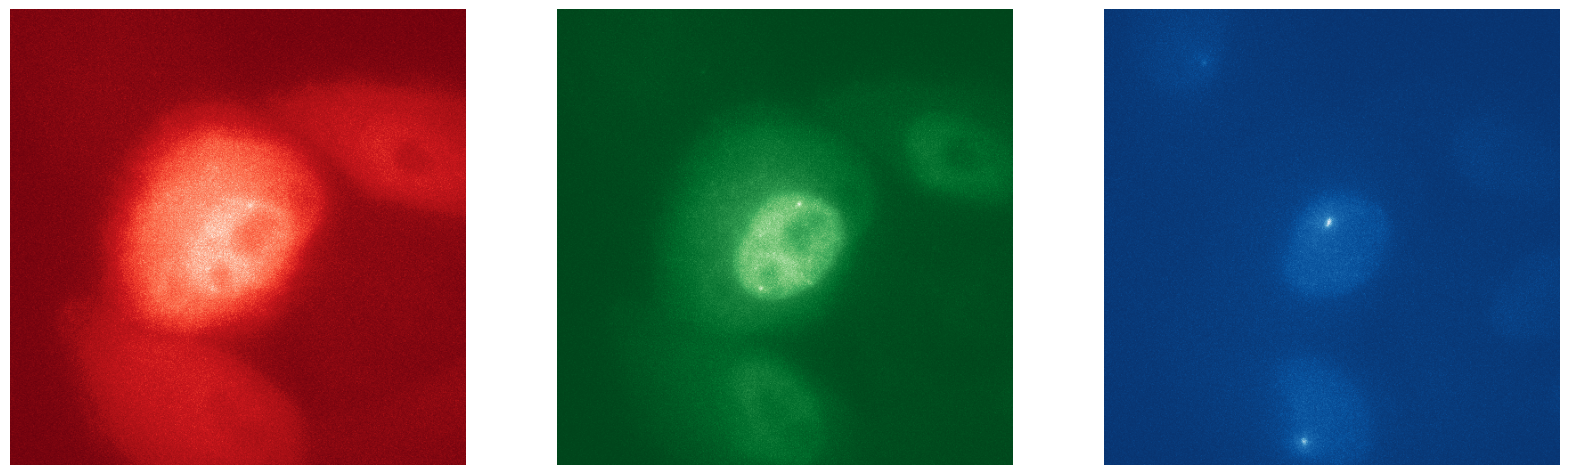

In [18]:
# Downloading test image

# Here we will download a test image again from the publication: 
# Forero-Quintero, L.S., Raymond, W., Handa, T. et al. "Live-cell imaging reveals the spatiotemporal organization 
# of endogenous RNA polymerase II phosphorylation at a single gene". Nat Commun 12, 3158 (2021). 
# https://doi.org/10.1038/s41467-021-23417-0

urls = ['https://ndownloader.figshare.com/files/26751209']
urllib.request.urlretrieve(urls[0], './image_cell.tif')
figName = './image_cell.tif'
image_complete = imread(figName)

print('image shape: ', image_complete.shape)

# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1,3, figsize=(20, 7))
ax[0].imshow(image_complete[0,:,:,0],cmap='Reds_r')
ax[1].imshow(image_complete[0,:,:,1],cmap='Greens_r')
ax[2].imshow(image_complete[0,:,:,2],cmap='Blues_r')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

In [19]:
img = image_complete[0,:,:,0]

When running CelPose, we need to choose a few parameters. The most important ones are:
* **model_type**: The type of model to use. The default is "cyto" for cytoplasm, but there are also models for "nuclei" and "cyto2" (for nuclei or cytoplasm with additional images).
* **diameter**: The diameter of the cells in pixels. If you don't know the diameter, you can set it to 0 and the algorithm will try to estimate it.
* **channels**: List of channels, either of length 2 or of length number of images by 2. First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue). Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue). For instance, to segment grayscale images, input [0,0]. To segment images with cells in green and nuclei in blue, input [2,3]. To segment one grayscale image and one image with cells in green and nuclei in blue, input [[0,0], [2,3]]. Defaults to [0,0].
* **channel_axis**: The axis of the image that contains the channels. For example, if the image is in the format (height, width, channels), then the channel axis is 2. If the image is in the format (channels, height, width), then the channel axis is 0. If the image is in the format (height, channels, width), then the channel axis is 1.

Want to learn more?  Type `help(models)` in the cell below to see the documentation and to see more of the optional inputs.

In [20]:
import cellpose
help(models)

Help on module cellpose.models in cellpose:

NAME
    cellpose.models - Copyright © 2023 Howard Hughes Medical Institute, Authored by Carsen Stringer and Marius Pachitariu.

CLASSES
    builtins.object
        Cellpose
        CellposeModel
        SizeModel
    
    class Cellpose(builtins.object)
     |  Cellpose(gpu=False, model_type='cyto3', nchan=2, device=None, backbone='default')
     |  
     |  Main model which combines SizeModel and CellposeModel.
     |  
     |  Args:
     |      gpu (bool, optional): Whether or not to use GPU, will check if GPU available. Defaults to False.
     |      model_type (str, optional): Model type. "cyto"=cytoplasm model; "nuclei"=nucleus model; 
     |          "cyto2"=cytoplasm model with additional user images; 
     |          "cyto3"=super-generalist model; Defaults to "cyto3".
     |      device (torch device, optional): Device used for model running / training. Overrides gpu input. Recommended if you want to use a specific GPU (e.g. torch.

/Users/munsky/anaconda3/envs/cellpose-env/lib/python3.10/site-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fi

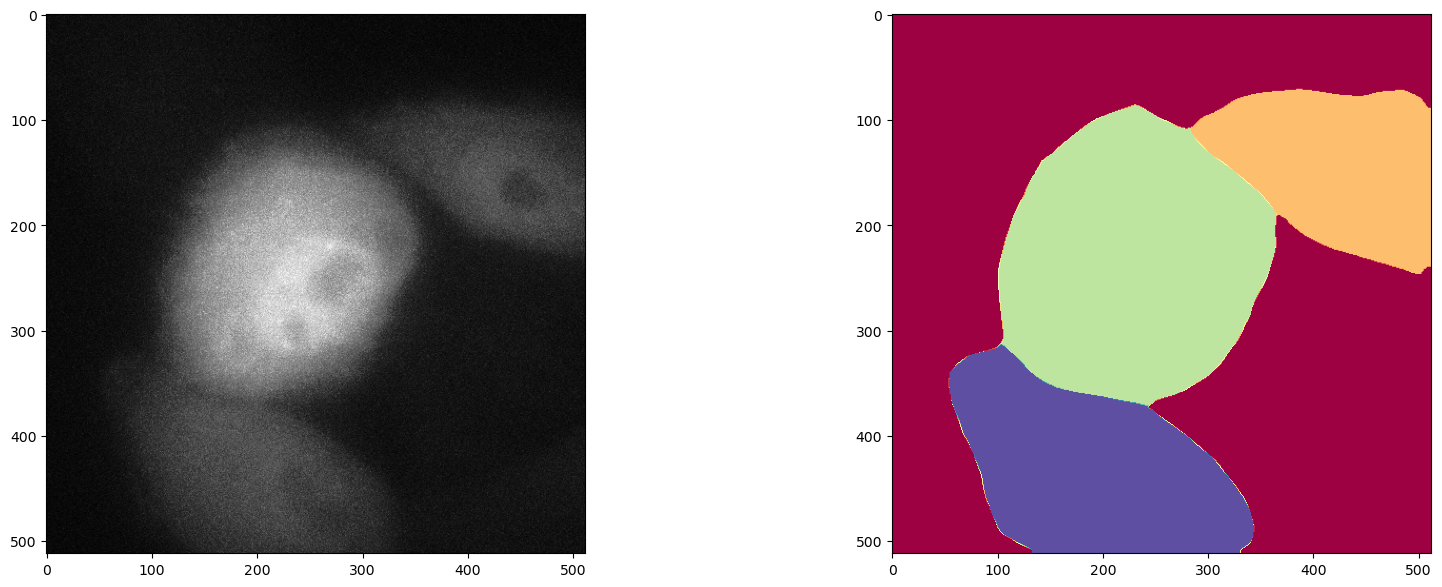

Values in mask:  [0 1 2 3]


In [21]:
# RUN CELLPOSE
model = models.Cellpose(model_type='cyto') # model_type='cyto' or model_type='nuclei'
masks  = model.eval(img, diameter=200)[0]
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1,2, figsize=(20, 7))
ax[0].imshow(img,cmap='Greys_r')
ax[1].imshow(masks,cmap='Spectral')
# ax[0].axis('off')
# ax[1].axis('off')
plt.show()
print('Values in mask: ', np.unique (masks))

In [22]:
# Let's see what evaluation information we can get from our model
help(model.eval)

Help on method eval in module cellpose.models:

eval(x, batch_size=8, channels=[0, 0], channel_axis=None, invert=False, normalize=True, diameter=30.0, do_3D=False, **kwargs) method of cellpose.models.Cellpose instance
    Run cellpose size model and mask model and get masks.
    
    Args:
        x (list or array): List or array of images. Can be list of 2D/3D images, or array of 2D/3D images, or 4D image array.
        batch_size (int, optional): Number of 224x224 patches to run simultaneously on the GPU. Can make smaller or bigger depending on GPU memory usage. Defaults to 8.
        channels (list, optional): List of channels, either of length 2 or of length number of images by 2. First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue). Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue). For instance, to segment grayscale images, input [0,0]. To segment images with cells in green and nuclei in blue, input [2,3]. To 

### 4.C.2. Segmenting nuclei and cytosol

Let's try CellPose on a few different images with more cells. For this, we will use some smFISH images from our lab.

In [23]:
# Downloading Fluorescence In Situ Hybridization (FISH) data
# Downloading the image to our local computer

urls = ['https://github.com/MunskyGroup/FISH_Processing/raw/main/dataBases/example_data/ROI002_XY1620755646_Z00_T0_merged.tif']
print('Downloading file...')
urllib.request.urlretrieve(urls[0], './ROI001_XY1620755243_Z00_T0_merged.tif')
figName = './ROI001_XY1620755243_Z00_T0_merged.tif'
images_FISH = imread(figName)

# The image has the following dimensions [Z,Y,X,C]
print('The image has the following dimensions [Z,Y,X,C]: ' ,images_FISH.shape)

# For segmentation, we will select the central  slice.
image_to_segment= images_FISH[10,:,:,:]


The image has the following dimensions [Z,Y,X,C]:  (23, 928, 624, 3)


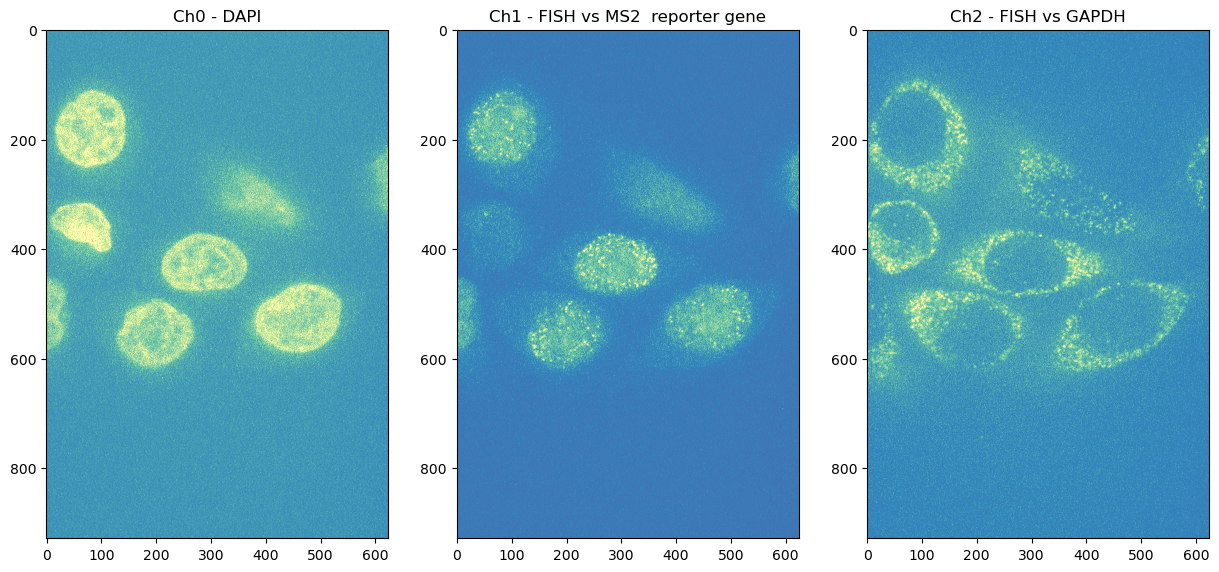

In [24]:
fig, ax = plt.subplots(1,3, figsize=(15, 8))
zSlice = 10
ax[0].imshow(images_FISH[zSlice,:,:,0],cmap='Spectral_r')
ax[0].set(title='Ch0 - DAPI')
ax[1].imshow(images_FISH[zSlice,:,:,1],cmap='Spectral_r')
ax[1].set(title= 'Ch1 - FISH vs MS2  reporter gene' )
ax[2].imshow(images_FISH[zSlice,:,:,2],cmap='Spectral_r')
ax[2].set(title= 'Ch2 - FISH vs GAPDH' )
plt.show()

In [25]:
help(models.Cellpose)

Help on class Cellpose in module cellpose.models:

class Cellpose(builtins.object)
 |  Cellpose(gpu=False, model_type='cyto3', nchan=2, device=None, backbone='default')
 |  
 |  Main model which combines SizeModel and CellposeModel.
 |  
 |  Args:
 |      gpu (bool, optional): Whether or not to use GPU, will check if GPU available. Defaults to False.
 |      model_type (str, optional): Model type. "cyto"=cytoplasm model; "nuclei"=nucleus model; 
 |          "cyto2"=cytoplasm model with additional user images; 
 |          "cyto3"=super-generalist model; Defaults to "cyto3".
 |      device (torch device, optional): Device used for model running / training. Overrides gpu input. Recommended if you want to use a specific GPU (e.g. torch.device("cuda:1")). Defaults to None.
 |  
 |  Attributes:
 |      device (torch device): Device used for model running / training.
 |      gpu (bool): Flag indicating if GPU is used.
 |      diam_mean (float): Mean diameter for cytoplasm model.
 |      cp (

(928, 624)


/Users/munsky/anaconda3/envs/cellpose-env/lib/python3.10/site-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fi

number of detected cells:  8


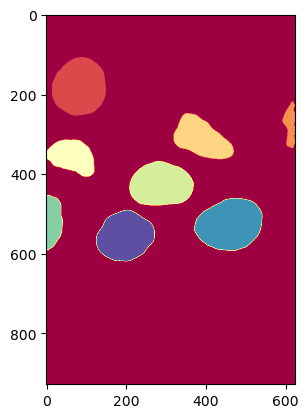

In [26]:
# Segmenting the nuclei
img_nuc = images_FISH[zSlice,:,:,0]
print(img_nuc.shape)
use_GPU = False  # Set to True if you have a GPU - this will make it MUCH faster.
model = models.Cellpose(gpu=use_GPU) # model_type='cyto' or model_type='nuclei'
masks_nuc = model.eval(img_nuc, diameter=100)[0]
print('number of detected cells: ', np.max(masks_nuc))
plt.imshow(masks_nuc,cmap='Spectral')
plt.show()

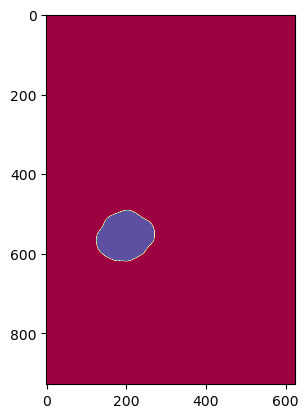

In [27]:
plt.imshow(masks_nuc==8,cmap='Spectral')
plt.show()

(928, 624, 3)


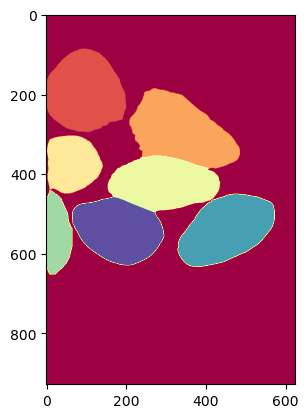

In [28]:
# Segmenting the cytosol
img_cyto = images_FISH[zSlice,:,:,:]
print(img_cyto.shape)
use_GPU = False
model = models.Cellpose(gpu=use_GPU, model_type='cyto') # model_type='cyto', 'cyto2' or model_type='nuclei'
masks_cyto, flows, styles, diams = model.eval(img_cyto, diameter=200)
plt.imshow(masks_cyto,cmap='Spectral')
plt.show()

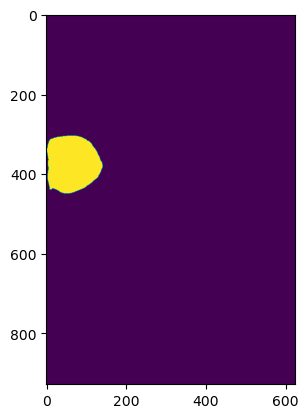

In [29]:
plt.imshow(masks_cyto==3)
plt.show()

## 4.D. Getting object properties
### 4.D.1. Calculating the area/intensity of each cell in the image

In [30]:
# How could we access just the pixels forming a specific cell's nucleus and find the that nucleus's area?
cell_number = 5
area = np.sum(masks_nuc==cell_number)
print(f'The area of nucleus number {cell_number} is {area} pixels.')

The area of nucleus number 5 is 14012 pixels.


In [31]:
# What is the average intensity of green in cell 4's nucleus?
color = 1
total_intensity = np.sum(images_FISH[zSlice,:,:,color][masks_nuc==cell_number])
area = np.sum(masks_nuc==cell_number)
average_intensity = total_intensity/area
print(f'The average intensity of color {color} in nucleus number {cell_number} is {average_intensity} fluorescence units per pixel.')

The average intensity of color 1 in nucleus number 5 is 893.6036968312875 fluorescence units per pixel.


## 4.E. Visualizing the results of nuclear and cytosolic segmentation.

To associate nuclei with their corresponding cytosol, we will simply find the average location of each nucleus and then see which cytosol contains that location.

In [32]:
# Associating each nucleus with its corresponding cytosol
nucleus_indices = np.zeros(np.max(masks_cyto)+1)
for i in range(1,np.max(masks_nuc)+1):
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

print(nucleus_indices)

[2. 1. 3. 4. 5. 6. 7. 8.]


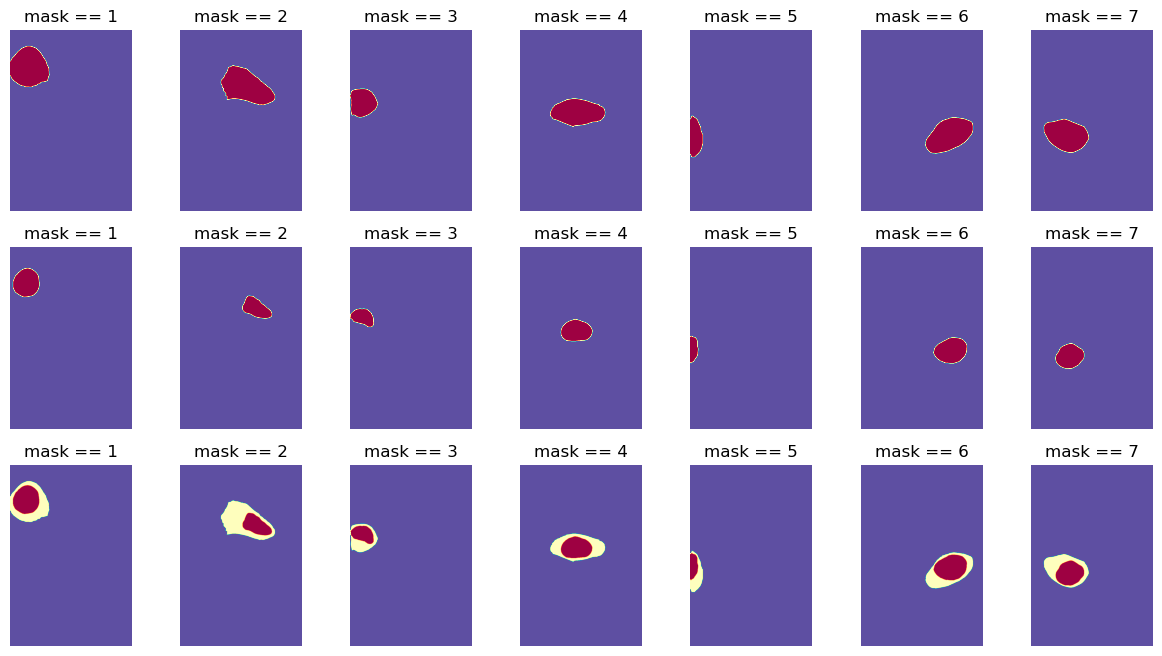

In [33]:
# Show the cytoplasms and corresponding nuclei
number_detected_cells = np.max(masks_cyto)

fig, ax = plt.subplots(3,number_detected_cells, figsize=(15, 8))
for i in range (1,number_detected_cells+1):
  selected_cyto_mask = masks_cyto==i
  ax[0,i-1].imshow(selected_cyto_mask,cmap='Spectral_r')
  ax[0,i-1].set(title='mask == ' + str(i) )
  ax[0,i-1].axis('off')

  # find which nucleus is associated with the cytosol
  selected_nuc_mask = masks_nuc==nucleus_indices[i]
  ax[1,i-1].imshow(selected_nuc_mask,cmap='Spectral_r')
  ax[1,i-1].set(title='mask == ' + str(i) )
  ax[1,i-1].axis('off')

  # find which nucleus is associated with the cytosol
  combined = selected_nuc_mask.astype(int) + selected_cyto_mask.astype(int)
  ax[2,i-1].imshow(combined,cmap='Spectral_r')
  ax[2,i-1].set(title='mask == ' + str(i) )
  ax[2,i-1].axis('off')
plt.show()

In [34]:
# Make a list of the areas of all nuclei and cytosols
# Note: The areas are in pixels

list_cyt_areas = []
list_nuc_areas = []
for i in range (1,number_detected_cells+1):
  selected_cyto_mask = masks_cyto==i
  area_cyto = np.sum(selected_cyto_mask)
  list_cyt_areas.append(area_cyto)

  selected_nuc_mask = masks_nuc==nucleus_indices[i]
  area_nuc = np.sum(selected_nuc_mask)
  list_nuc_areas.append(area_nuc)

  print(f'Cell {i} has a cytosol area of {area_cyto} pixels and a nucleus area of {area_nuc} pixels.')


Cell 1 has a cytosol area of 31902 pixels and a nucleus area of 15544 pixels.
Cell 2 has a cytosol area of 35077 pixels and a nucleus area of 10813 pixels.
Cell 3 has a cytosol area of 16066 pixels and a nucleus area of 7931 pixels.
Cell 4 has a cytosol area of 28743 pixels and a nucleus area of 14012 pixels.
Cell 5 has a cytosol area of 10829 pixels and a nucleus area of 4600 pixels.
Cell 6 has a cytosol area of 30677 pixels and a nucleus area of 17054 pixels.
Cell 7 has a cytosol area of 28189 pixels and a nucleus area of 13867 pixels.


### 4.D.2. Calculating the mean intensity of each cell in the image

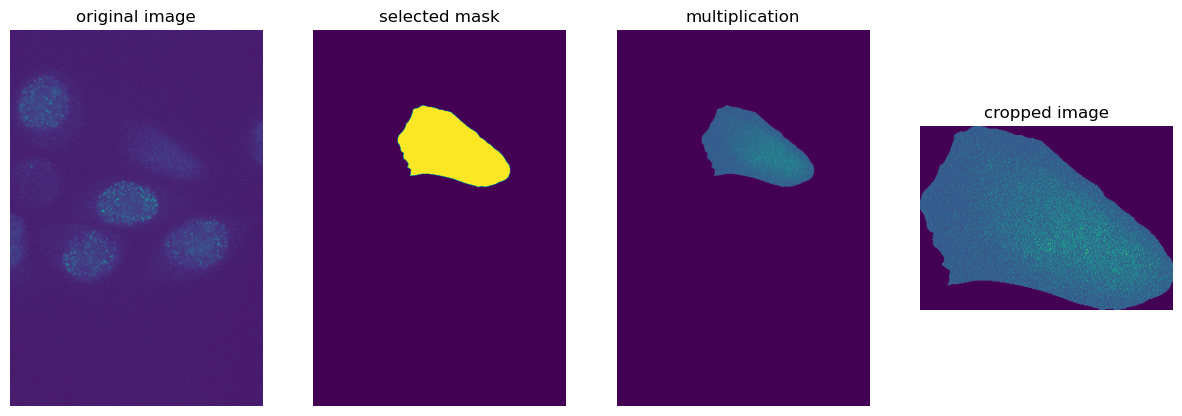

In [35]:
# Here is how we can select the pixels forming a cell, by multiplying the mask by the image

cell_number = 2
color = 1

fig, ax = plt.subplots(1,4, figsize=(15, 8))

# show original image
ax[0].imshow(img_cyto[:,:,color])
ax[0].set(title='original image')

# select a mask
selected_mask = masks_cyto == cell_number  # Select other cell label

# show the mask
ax[1].imshow(selected_mask)
ax[1].set(title='selected mask')

# multiply the mask by the image to plot only the selected cell
selected_cell_image = selected_mask*img_cyto[:,:,color]
ax[2].imshow(selected_cell_image)
ax[2].set(title='multiplication')

# crop the image to show only the selected cell
xvals = np.where(selected_mask)[1]
yvals = np.where(selected_mask)[0]
cropped_cell_image = selected_cell_image[yvals.min():yvals.max(),xvals.min():xvals.max()]
ax[3].imshow(cropped_cell_image)
ax[3].set(title='cropped image')

for i in range(len(ax)):
    ax[i].axis('off')

plt.show()

### 4.D.3. Using Scikit-Image to Draw the Segmentation Mask

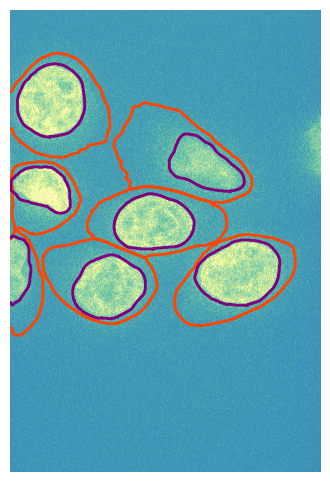

In [36]:
# Get region properties from the masks

# Draw region boundaries on the image
fig, ax = plt.subplots(1,1, figsize=(6, 6))
ax.imshow(img_cyto[:,:,0], cmap='Spectral_r')
ax.axis('off')

for i in range (1,number_detected_cells+1):
    contours_cyto = measure.find_contours(masks_cyto==i, level=0.5)
    for contour in contours_cyto:
        ax.plot(contour[:,1],contour[:,0], linewidth=2, color='orangered')
    
    contours_nuc = measure.find_contours(masks_nuc==nucleus_indices[i], level=0.5)
    for contour in contours_nuc:
        ax.plot(contour[:,1],contour[:,0], linewidth=2, color='purple')
plt.show()

In [37]:
# Let' compute the mean intensity for each cell in the image.
list_mean_intensities = []
for iMask in range (1,number_detected_cells+1):
  selected_mask = masks_cyto==iMask
  mean_intensity = []
  for iColor in range(3):
    selected_color_image = selected_mask*img_cyto[:,:,iColor]
    mean_intensity.append(selected_color_image[np.nonzero(selected_color_image)].mean())
  list_mean_intensities.append(mean_intensity)

# Convert the list to a pandas dataframe and display
import pandas as pd
df = pd.DataFrame(list_mean_intensities, columns=['Ch0', 'Ch1', 'Ch2'])
df

Ch0         Ch1         Ch2
0  739.723873  692.412012  776.262585
1  603.913562  595.798158  694.711663
2  779.952384  577.929167  835.659778
3  704.676791  731.839474  791.358070
4  624.739219  622.212947  715.409087
5  740.288359  692.064837  723.436353
6  688.241584  681.890702  778.562915

# 5. Spot detection

The principle of spot detection is to identify the location of a spot in an image. This is typically done by identifying the center of the spot and then using a mask to identify the area around the spot.

The steps for spot detection are as follows:
1.   Filtering
2.   Thresholding
3.   Binarization
4.   Labeling

## 5.A. Spot detection using the Laplacian of Gaussian (LoG) method
The Laplacian of Gaussian (LoG) method is a popular method for spot detection. The LoG method works by convolving the image with a Gaussian filter and then applying the Laplacian operator to the result. The Laplacian operator is a second-order derivative operator that highlights regions of rapid intensity change in an image.
After applying the Laplacian operator, the result is thresholded to create a binary image. The binary image is then labeled to identify the spots in the image.
The LoG method is a popular method for spot detection because it is simple to implement and works well for a wide variety of images. The LoG method is also computationally efficient, making it suitable for real-time applications.

/var/folders/gs/29wgt2xj1jj873ytknj55rsr0000gp/T/ipykernel_74335/2674694087.py:23: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


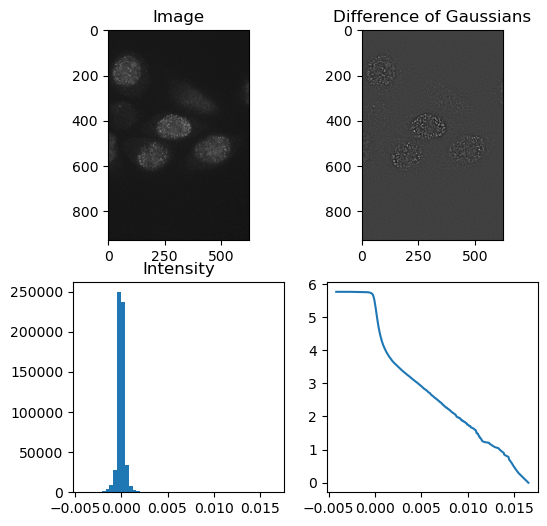

intensity range:  -0.004176958905956665 0.016580984698187026


In [38]:
# Selecting the color channel with RNA spots
zSlice = 10
iChannel = 1
img_spots = images_FISH[zSlice,:,:,iChannel]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_spots,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_spots,low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

In [39]:
threshold = 0.0055

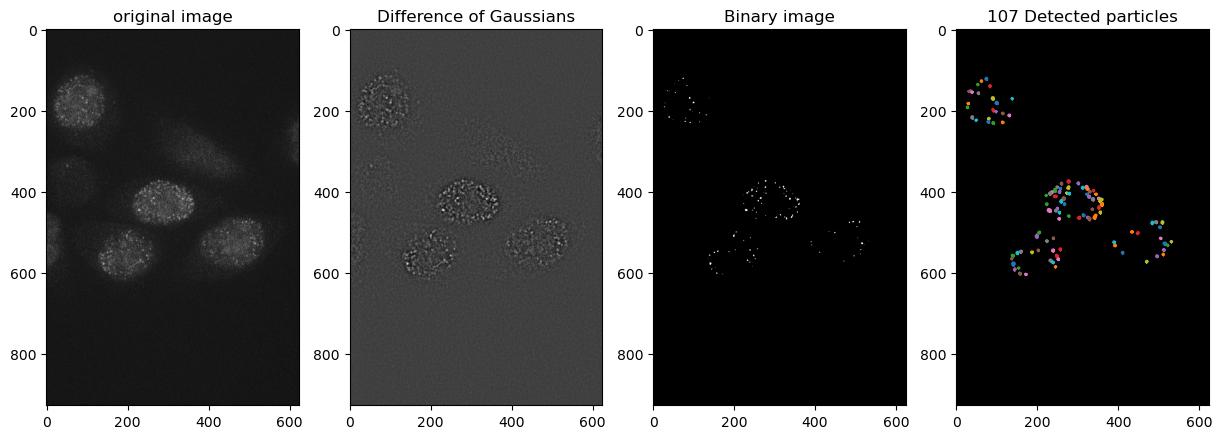

In [40]:
# Show original image in MS2 channel
fig, ax = plt.subplots(1,4, figsize=(15, 6))
ax[0].imshow(img_spots,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_spots_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
img_spots_binary = img_spots_filtered.copy()
img_spots_binary[img_spots_binary>=threshold] = threshold # Making spots above the threshold equal to the threshold value.
img_spots_binary[img_spots_binary<threshold] = 0 # Making spots below the threshold equal to 0.
ax[2].imshow(img_spots_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_spots_binary[img_spots_binary!=0] = 1 # Binarization
ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
spot_contours = measure.find_contours(img_spots_binary, 0.5)
for contour in spot_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(spot_contours))+' Detected particles' )

plt.show()

In [41]:
# Counting the detected particles in each cell

list_cytosol_particles = np.zeros(number_detected_cells)
list_nuclear_particles = np.zeros(number_detected_cells)

# Loop through the cytosol masks
for i in range(len(spot_contours)):
    # Find the position of the particle
    posn = np.mean(spot_contours[i], axis=0).astype(int)

    # Check which cyto mask is the particle in
    cell_num = masks_cyto[posn[0], posn[1]]
    if cell_num>0:
        list_cytosol_particles[cell_num-1] += 1

        # Check if the particle is also in the nucleus
        if masks_nuc[posn[0], posn[1]] == nucleus_indices[cell_num]:
            list_nuclear_particles[cell_num-1] += 1

# Add the number of particles to the dataframe
df['Particles in cytosol'] = list_cytosol_particles
df['Particles in nucleus'] = list_nuclear_particles
df

Ch0         Ch1         Ch2  Particles in cytosol  \
0  739.723873  692.412012  776.262585                  23.0   
1  603.913562  595.798158  694.711663                   0.0   
2  779.952384  577.929167  835.659778                   0.0   
3  704.676791  731.839474  791.358070                  44.0   
4  624.739219  622.212947  715.409087                   0.0   
5  740.288359  692.064837  723.436353                  17.0   
6  688.241584  681.890702  778.562915                  23.0   

   Particles in nucleus  
0                  23.0  
1                   0.0  
2                   0.0  
3                  44.0  
4                   0.0  
5                  17.0  
6                  23.0

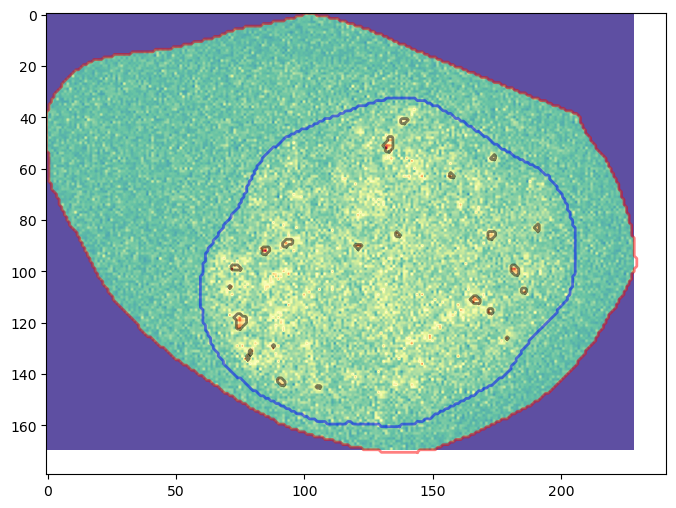

In [42]:
# Let's now look at individual cells in the image

cell_num = 7 # Choose which cell to look at
selected_cyto_mask = masks_cyto==cell_num
selected_nuc_mask = masks_nuc==nucleus_indices[cell_num]

# Crop the original image to show just the selected cell
image_cropped = img_cyto.copy()
image_cropped[~selected_cyto_mask] = 0

# remove rows and columns that are all zeros
rows = np.any(image_cropped[:,:,0], axis=1)
rlims = [np.min(np.where(rows)), np.max(np.where(rows))]
cols = np.any(image_cropped[:,:,0,], axis=0)
clims = [np.min(np.where(cols)), np.max(np.where(cols))]
image_cropped = image_cropped[rlims[0]:rlims[1], clims[0]:clims[1], :]

# display the cropped image
fig, ax = plt.subplots(1,1, figsize=(8, 8))
ax.imshow(image_cropped[:,:,1],cmap='Spectral_r')

# draw the contours of the cytosol and nucleus
cyto_contours = measure.find_contours(selected_cyto_mask, 0.5)
nuc_contours = measure.find_contours(selected_nuc_mask, 0.5)
for contour in cyto_contours:
    ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)
for contour in nuc_contours:
    ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='b', alpha=0.5)

# Add the contours of the particles to the image
for contour in spot_contours:
    # Check if the particle is in the selected cell
    posn = np.mean(contour, axis=0).astype(int)
    if selected_cyto_mask[posn[0], posn[1]]:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='k', alpha=0.5)

plt.show()

## 5.B. Spot detection using TrackPy

![alt text](FigsA/Module_1_3/Slide8.png)

In [43]:
# Installing libraries
# %pip install trackpy
import trackpy as tp # Library for particle tracking

In [44]:
# This section generates an histograme with the intensity of the detected particles in the image.
particle_size = 5 # according to the documentation must be an odd number 3,5,7,9 etc.
minimal_intensity_for_selection = 0 # minimal intensity to detect a particle.
# "spots_detected_dataframe" is a pandas data freame that contains the infomation about the detected spots
spots_detected_dataframe = tp.locate(img_spots, diameter=particle_size, minmass=minimal_intensity_for_selection)

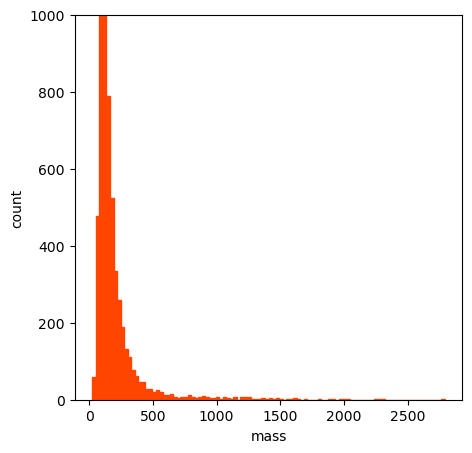

In [45]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.hist(spots_detected_dataframe['mass'], bins=100, color = "orangered", ec="orangered")
ax.set(xlabel='mass', ylabel='count')
ax.set_ylim([0,1000])
plt.show()

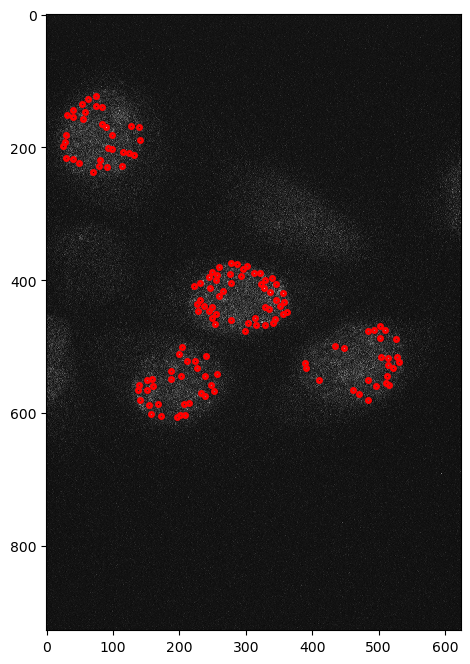

In [46]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
spots_detected_dataframe = tp.locate(img_spots,diameter=5, minmass=800) # "spots_detected_dataframe" is a pandas data freame that contains the infomation about the detected spots
tp.annotate(spots_detected_dataframe,img_spots,plot_style={'markersize': 3})  # tp.anotate is a trackpy function that displays the image with the detected spots
ax.axis('off')
plt.show()

In [47]:
spots_detected_dataframe.head()

y          x         mass      size       ecc      signal  \
759  121.966493  74.212687  1025.298307  1.242824  0.202133  164.002615   
795  126.822709  61.991633  1053.745000  1.185386  0.336913  192.878963   
850  135.038139  53.023466  1216.422848  1.165267  0.456605  236.462018   
866  137.668308  74.417056   834.254326  1.190559  0.614688  175.397405   
875  139.094325  82.973567  1365.378612  1.104266  0.162914  291.923223   

     raw_mass        ep  
759   16209.0  0.038516  
795   14624.0  0.046260  
850   13966.0  0.050473  
866   12992.0  0.058338  
875   16578.0  0.037071

In [48]:
help(tp.locate)

Help on function locate in module trackpy.feature:

locate(raw_image, diameter, minmass=None, maxsize=None, separation=None, noise_size=1, smoothing_size=None, threshold=None, invert=False, percentile=64, topn=None, preprocess=True, max_iterations=10, filter_before=None, filter_after=None, characterize=True, engine='auto')
    Locate Gaussian-like blobs of some approximate size in an image.
    
    Preprocess the image by performing a band pass and a threshold.
    Locate all peaks of brightness, characterize the neighborhoods of the peaks
    and take only those with given total brightness ("mass"). Finally,
    refine the positions of each peak.
    
    Parameters
    ----------
    raw_image : array (any dimensions)
        Image used for final characterization. Ideally, pixel values of
        this image are not rescaled, but it can also be identical to
        ``image``.
    image : array (same size as raw_image)
        Processed image used for centroid-finding and most particl

## 5.C. Extracting information from a Pandas dataframes

In [49]:
# Showing information for particle with mass larger than >
min_mass = 200
spots_detected_dataframe.loc[spots_detected_dataframe['mass']>min_mass ]

y           x         mass      size       ecc      signal  \
759   121.966493   74.212687  1025.298307  1.242824  0.202133  164.002615   
795   126.822709   61.991633  1053.745000  1.185386  0.336913  192.878963   
850   135.038139   53.023466  1216.422848  1.165267  0.456605  236.462018   
866   137.668308   74.417056   834.254326  1.190559  0.614688  175.397405   
875   139.094325   82.973567  1365.378612  1.104266  0.162914  291.923223   
...          ...         ...          ...       ...       ...         ...   
3716  601.983761  157.081453  1413.884789  1.148276  0.407451  254.516448   
3724  602.900813  201.464009   830.799189  1.103329  0.233531  171.754294   
3725  602.894010  208.547861   841.146696  1.116616  0.189644  173.974175   
3733  604.148767  171.561154  1004.755462  1.272427  0.136866  142.824240   
3748  606.760936  196.085656   917.938446  1.198878  0.219631  174.520194   

      raw_mass        ep  
759    16209.0  0.038516  
795    14624.0  0.046260  
850    13966.0  0.050473  
866    12992.0  0.058338  
875    16578.0  0.037071  
...        ...       ...  
3716   17542.0  0.033762  
3724   13250.0  0.056026  
3725   13900.0  0.050939  
3733   14228.0  0.048707  
3748   13199.0  0.056468  

[138 rows x 8 columns]

In [50]:
# Showing information for particles larger than a given size
min_size = 0.55
spots_detected_dataframe.loc[spots_detected_dataframe['size']>min_size]

y           x         mass      size       ecc      signal  \
759   121.966493   74.212687  1025.298307  1.242824  0.202133  164.002615   
795   126.822709   61.991633  1053.745000  1.185386  0.336913  192.878963   
850   135.038139   53.023466  1216.422848  1.165267  0.456605  236.462018   
866   137.668308   74.417056   834.254326  1.190559  0.614688  175.397405   
875   139.094325   82.973567  1365.378612  1.104266  0.162914  291.923223   
...          ...         ...          ...       ...       ...         ...   
3716  601.983761  157.081453  1413.884789  1.148276  0.407451  254.516448   
3724  602.900813  201.464009   830.799189  1.103329  0.233531  171.754294   
3725  602.894010  208.547861   841.146696  1.116616  0.189644  173.974175   
3733  604.148767  171.561154  1004.755462  1.272427  0.136866  142.824240   
3748  606.760936  196.085656   917.938446  1.198878  0.219631  174.520194   

      raw_mass        ep  
759    16209.0  0.038516  
795    14624.0  0.046260  
850    13966.0  0.050473  
866    12992.0  0.058338  
875    16578.0  0.037071  
...        ...       ...  
3716   17542.0  0.033762  
3724   13250.0  0.056026  
3725   13900.0  0.050939  
3733   14228.0  0.048707  
3748   13199.0  0.056468  

[138 rows x 8 columns]

In [51]:
# Extracting the y values for all particles
spots_detected_dataframe.y.values[0:10]

array([121.96649323, 126.82270943, 135.03813946, 137.66830828,
       139.09432466, 143.23523026, 146.66342823, 151.96061456,
       153.84853949, 156.53197056])

In [52]:
# Save the particles trajectories and intensities as a CSV file
spots_detected_dataframe.to_csv(r'./detected_spots.csv', index = False)

In [53]:
def spots_in_mask(df,masks):
    # extracting the contours in the image
    coords = np.array([df.y, df.x]).T # These are the points detected by trackpy
    coords_int = np.round(coords).astype(int)  # or np.floor, depends
    values_at_coords = masks[tuple(coords_int.T)] # If 1 the value is in the mask
    df['In Mask']=values_at_coords # Check if pts are on/in polygon mask
    return df

In [54]:
dataframe_spots_in_nuc = spots_in_mask(df=spots_detected_dataframe, masks= masks_nuc)

In [55]:
dataframe_spots_in_nuc

y           x         mass      size       ecc      signal  \
759   121.966493   74.212687  1025.298307  1.242824  0.202133  164.002615   
795   126.822709   61.991633  1053.745000  1.185386  0.336913  192.878963   
850   135.038139   53.023466  1216.422848  1.165267  0.456605  236.462018   
866   137.668308   74.417056   834.254326  1.190559  0.614688  175.397405   
875   139.094325   82.973567  1365.378612  1.104266  0.162914  291.923223   
...          ...         ...          ...       ...       ...         ...   
3716  601.983761  157.081453  1413.884789  1.148276  0.407451  254.516448   
3724  602.900813  201.464009   830.799189  1.103329  0.233531  171.754294   
3725  602.894010  208.547861   841.146696  1.116616  0.189644  173.974175   
3733  604.148767  171.561154  1004.755462  1.272427  0.136866  142.824240   
3748  606.760936  196.085656   917.938446  1.198878  0.219631  174.520194   

      raw_mass        ep  In Mask  
759    16209.0  0.038516        1  
795    14624.0  0.046260        1  
850    13966.0  0.050473        1  
866    12992.0  0.058338        1  
875    16578.0  0.037071        1  
...        ...       ...      ...  
3716   17542.0  0.033762        8  
3724   13250.0  0.056026        8  
3725   13900.0  0.050939        8  
3733   14228.0  0.048707        8  
3748   13199.0  0.056468        8  

[138 rows x 9 columns]

In [56]:
# Extracting only the spots located on a given cell
selected_cell = 1 # Test cell 1
dataframe_spots_cell_N = dataframe_spots_in_nuc[dataframe_spots_in_nuc['In Mask']==selected_cell]
dataframe_spots_cell_N

y           x         mass      size       ecc      signal  \
759   121.966493   74.212687  1025.298307  1.242824  0.202133  164.002615   
795   126.822709   61.991633  1053.745000  1.185386  0.336913  192.878963   
850   135.038139   53.023466  1216.422848  1.165267  0.456605  236.462018   
866   137.668308   74.417056   834.254326  1.190559  0.614688  175.397405   
875   139.094325   82.973567  1365.378612  1.104266  0.162914  291.923223   
898   143.235230   39.117539   882.250288  1.153402  0.123962  145.652798   
928   146.663428   57.510974   831.971787  1.081970  0.308757  180.365282   
956   151.960615   30.955810  1082.487080  1.058590  0.422452  250.336270   
971   153.848539   39.272690  1017.680894  1.065807  0.447764  256.494648   
988   156.531971   54.710672  1320.667715  1.167970  0.357254  259.949785   
1040  164.684879   84.025241   997.567704  1.090095  0.338230  195.788080   
1056  167.585831  126.845881   888.847271  1.139632  0.159423  155.490090   
1059  169.312485   90.023291  1906.581872  1.212299  0.162371  295.727454   
1060  169.392130  138.365370  1071.405580  1.227833  0.247558  208.856731   
1136  181.022335   98.915181  1797.852489  1.148586  0.417503  358.618097   
1141  181.839644   29.236292  1097.542882  1.017880  0.504523  286.695763   
1175  188.180516  139.920078   814.454425  1.156861  0.432180  157.781580   
1195  191.779587   27.726105  1478.189712  1.221041  0.439157  238.798263   
1227  197.713077   24.220612   806.004557  1.218342  0.179149  121.332576   
1243  200.640848   92.171372   882.098119  1.303439  0.130111  143.486624   
1254  202.542547   97.927332   921.993308  1.220518  0.165256  180.418989   
1280  206.818773  114.665044  1320.291767  1.222881  0.060800  202.483526   
1288  208.197847  124.569279   896.482586  1.140517  0.379472  169.239027   
1307  211.167511  130.905051  1384.211791  1.129622  0.398801  272.857315   
1332  215.293323   29.536414   862.817383  1.219541  0.332753  155.767575   
1354  217.634656   38.955066   886.063470  1.365437  0.280743  133.085410   
1361  219.176487   79.931729  1366.452748  1.173934  0.149410  230.912317   
1386  222.884764   48.322831   988.356990  1.251953  0.174568  151.954394   
1412  227.568169   79.122732  1354.574598  1.196395  0.125307  229.220553   
1417  228.779383  113.932562  1251.923032  1.069793  0.151644  270.619532   
1424  230.132831   91.241808  1576.723758  1.156327  0.305181  296.873198   
1468  236.804138   69.373645   935.276786  1.264415  0.065616  148.221772   

      raw_mass        ep  In Mask  
759    16209.0  0.038516        1  
795    14624.0  0.046260        1  
850    13966.0  0.050473        1  
866    12992.0  0.058338        1  
875    16578.0  0.037071        1  
898    13052.0  0.057783        1  
928    14809.0  0.045199        1  
956    14266.0  0.048461        1  
971    15334.0  0.042438        1  
988    18507.0  0.030993        1  
1040   15628.0  0.041034        1  
1056   13659.0  0.052713        1  
1059   21116.0  0.025368        1  
1060   14758.0  0.045487        1  
1136   20551.0  0.026406        1  
1141   16044.0  0.039199        1  
1175   13074.0  0.057583        1  
1195   17394.0  0.034231        1  
1227   14191.0  0.048949        1  
1243   16734.0  0.036492        1  
1254   16691.0  0.036650        1  
1280   16363.0  0.037899        1  
1288   14638.0  0.046178        1  
1307   16504.0  0.037352        1  
1332   14896.0  0.044717        1  
1354   17202.0  0.034859        1  
1361   16901.0  0.035892        1  
1386   15904.0  0.039798        1  
1412   18196.0  0.031834        1  
1417   16953.0  0.035709        1  
1424   17622.0  0.033514        1  
1468   14181.0  0.049015        1

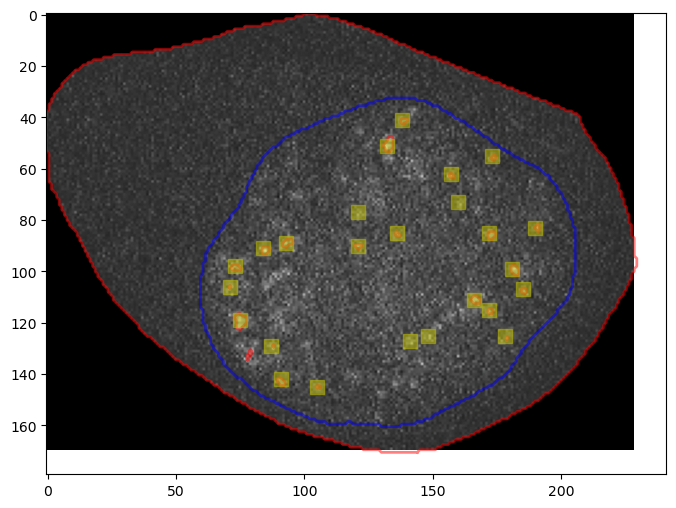

In [57]:
# Let's now look at individual cells in the image
# We will plot the detected spots of the selected cell using both particle finding approaches
img_spots_filtered_thresholded = img_spots_filtered.copy()
img_spots_filtered_thresholded[img_spots_filtered_thresholded<=0] = 0
img_spots_filtered_thresholded = 255*img_spots_filtered_thresholded/np.max(img_spots_filtered_thresholded)
spots_detected_dataframe = tp.locate(img_spots_filtered_thresholded, diameter=5, minmass=110) # "spots_detected_dataframe" is a pandas data freame that contains the infomation about the detected spots

cell_num = 7 # Choose which cell to look at
selected_cyto_mask = masks_cyto==cell_num
selected_nuc_mask = masks_nuc==nucleus_indices[cell_num]

# Crop the original image to show just the selected cell
image_cropped = img_cyto.copy()
image_cropped[~selected_cyto_mask] = 0

# remove rows and columns that are all zeros
rows = np.any(image_cropped[:,:,0], axis=1)
rlims = [np.min(np.where(rows)), np.max(np.where(rows))]
cols = np.any(image_cropped[:,:,0,], axis=0)
clims = [np.min(np.where(cols)), np.max(np.where(cols))]
image_cropped = image_cropped[rlims[0]:rlims[1], clims[0]:clims[1], :]

# display the cropped image
fig, ax = plt.subplots(1,1, figsize=(8, 8))
ax.imshow(image_cropped[:,:,1],cmap='gray')

# draw the contours of the cytosol and nucleus
cyto_contours = measure.find_contours(selected_cyto_mask, 0.5)
nuc_contours = measure.find_contours(selected_nuc_mask, 0.5)
for contour in cyto_contours:
    ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)
for contour in nuc_contours:
    ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='b', alpha=0.5)

# Add the contours where our first approach found particles in the image
for contour in spot_contours:
    # Check if the particle is in the selected cell
    posn = np.mean(contour, axis=0).astype(int)
    if selected_cyto_mask[posn[0], posn[1]]:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)

# Add red 'x' markers where trackpy found particles to the image
for i in range(len(spots_detected_dataframe)):
    # Check if the particle is in the selected cell
    posn = np.array([spots_detected_dataframe.y.values[i], spots_detected_dataframe.x.values[i]]).astype(int)
    if selected_cyto_mask[posn[0], posn[1]]:
        ax.plot(posn[1]-clims[0], posn[0]-rlims[0], 's', color='y', alpha=0.5, markersize=10)

plt.show()

In [58]:
# Lets now look at the detected spots individually to see which are found with both methods

# Create a matrix showing the distance between the spots detected by trackpy and the spots detected by the mask
dist_matrix = np.zeros((len(spots_detected_dataframe), len(spot_contours)))
for i in range(len(spots_detected_dataframe)):
    for j in range(len(spot_contours)):
        dist_matrix[i,j] = np.linalg.norm(np.array([spots_detected_dataframe.y.values[i], spots_detected_dataframe.x.values[i]]) - np.mean(spot_contours[j], axis=0))

maxDist = 10
indexList = []
while np.min(dist_matrix) < maxDist:
    # Find the shortest distance in the matrix and record the indexes
    indexes = np.unravel_index(np.argmin(dist_matrix, axis=None), dist_matrix.shape)
    indexList.append(indexes)

    # Set all entries in the row and column of the minimum distance to infinity
    dist_matrix[indexes[0],:] = np.inf
    dist_matrix[:,indexes[1]] = np.inf

print('Number of matches: ', len(indexList))
print('Number TrackPy Leftover: ', len(spots_detected_dataframe)-len(indexList))
print('Number Mask Leftover: ', len(spot_contours)-len(indexList))

Number of matches:  101
Number TrackPy Leftover:  16
Number Mask Leftover:  6


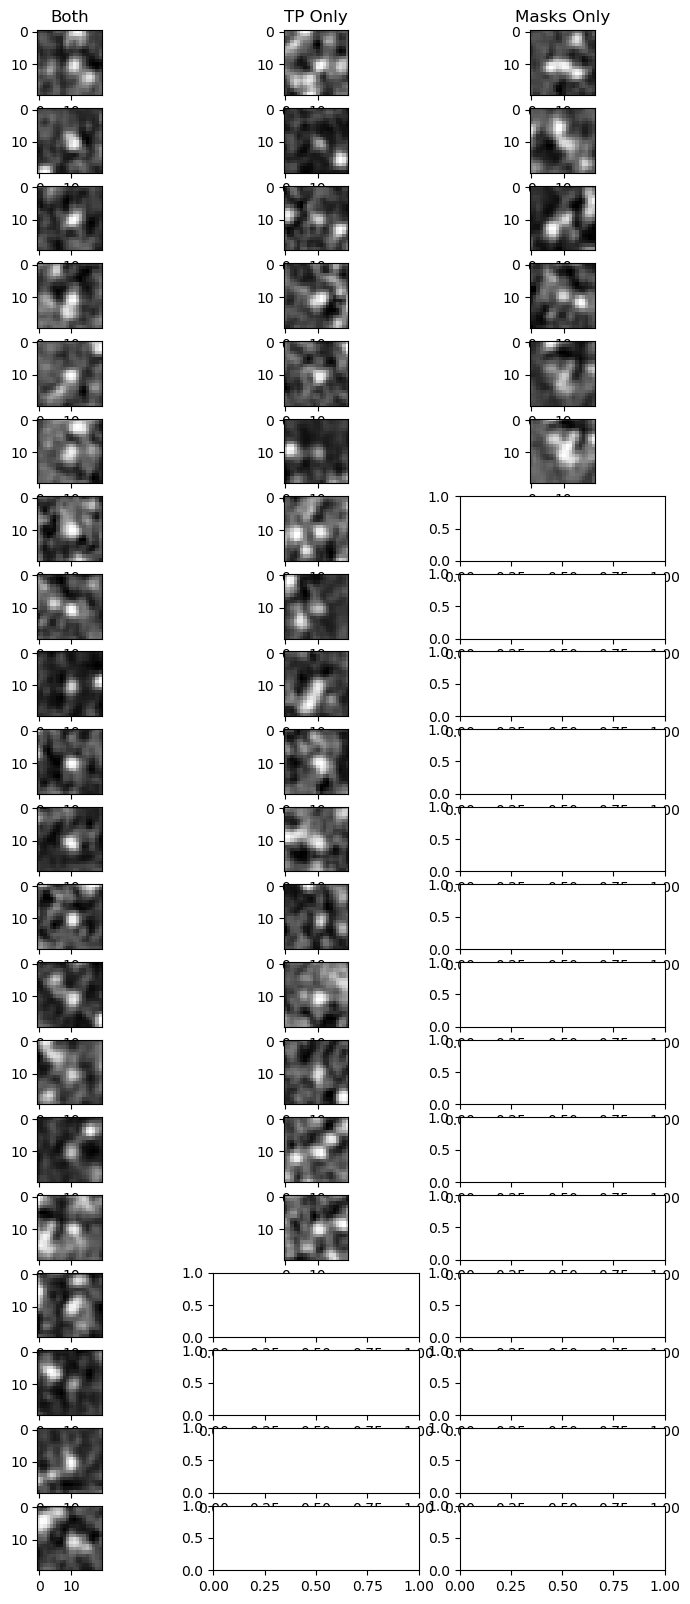

In [59]:
# Now let's look at the individual spots to see if we can determine which approach is better

# Create figure with three columns of 20 images
fig, ax = plt.subplots(20,3, figsize=(9, 20))

img_to_show = img_spots_filtered

# Loop through the first 20 matches, and make a plot for each
for i in range(20):
    # Plot the image
    posn = np.array([spots_detected_dataframe.y.values[indexList[i][0]], spots_detected_dataframe.x.values[indexList[i][0]]]).astype(int)
    ax[i,0].imshow(img_to_show[posn[0]-10:posn[0]+10,posn[1]-10:posn[1]+10],cmap='Greys_r')
    if i ==0:
        ax[i,0].set(title='Both')

# Loop through the first 20 spots detected onl by trackpy
trackPyLeftover = np.setdiff1d(np.arange(len(spots_detected_dataframe)), np.array(indexList)[:,0])
for j in range(min(20,len(trackPyLeftover))):
    i = trackPyLeftover[j]
    posn = np.array([spots_detected_dataframe.y.values[i], spots_detected_dataframe.x.values[i]]).astype(int)
    ax[j,1].imshow(img_to_show[posn[0]-10:posn[0]+10,posn[1]-10:posn[1]+10],cmap='Greys_r')
    if j ==0:
        ax[j,1].set(title='TP Only')

# Loop through the first 20 spots detected only by the mask
maskLeftover = np.setdiff1d(np.arange(len(spot_contours)), np.array(indexList)[:,1])
for j in range(min(20,len(maskLeftover))):
    i = maskLeftover[j]
    posn = np.mean(spot_contours[i], axis=0).astype(int)
    ax[j,2].imshow(img_to_show[posn[0]-10:posn[0]+10,posn[1]-10:posn[1]+10],cmap='Greys_r')
    if j ==0:
        ax[j,2].set(title='Masks Only')

plt.show()

- Spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Spot detection using [FISH Processing](https://colab.research.google.com/drive/1CQx4e5MQ0ZsZSQgqtLzVVh53dAg4uaQj?usp=sharing)

# References

*  Image downloaded from https://figshare.com from publication: "Forero-Quintero, Linda, William Raymond, Tetsuya Handa, Matthew Saxton, Tatsuya Morisaki, Hiroshi Kimura, Edouard Bertrand, Brian Munsky, and Timothy Stasevich. "Live-cell imaging reveals the spatiotemporal organization of endogenous RNA polymerase II phosphorylation at a single gene." (2020)."

* "Fox, Z.R., Fletcher, S., Fraisse, A., Aditya, C., Sosa-Carrillo, S., Gilles, S., Bertaux, F., Ruess, J. and Batt, G., 2021. MicroMator: Open and Flexible Software for Reactive Microscopy. bioRxiv. (2021)"